## Pipeline on translated data

In [524]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_metric,load_dataset,concatenate_datasets,load_from_disk, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification,AdamW,get_scheduler,TrainingArguments,Trainer

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm, trange

import csv

checkpoint = 'ufal/robeczech-base'
data_path = '/home/horyctom/experimental-tomas-horych/data/cs_data/'
TRAIN = 'train100k_cs.txt'
VALID = 'valid_cs.txt'
TEST = 'test_cs.txt'
NEW_VALID = 'new_data_cs.txt'

NEUTRAL = 0
FEMALE = 1
MALE = 2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [525]:
transformers.logging.set_verbosity(transformers.logging.ERROR)

In [558]:
def tokenize_function(data):
    return tokenizer(data['text'], truncation=True)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()
    
def compute_metrics(test_dataloader):
    metric = load_metric("f1")

    model.eval()
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
        
    return metric.compute(average='micro')

def eval_test(dl,model,labels):
    metric = load_metric("f1")
    metric_acc = load_metric("accuracy")

    preds = torch.Tensor([]).to(device)

    model.eval()
    for batch in dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits

        predictions = torch.argmax(logits, dim=-1)
        preds = torch.cat((preds,logits),0)
        metric.add_batch(predictions=predictions, references=batch["labels"])
        metric_acc.add_batch(predictions=predictions, references=batch["labels"])

    score = metric.compute(average="macro")
    score2 = metric_acc.compute()
    print("F1 score: " + str(score['f1']))
    print("Accuracy score: " + str(score2['accuracy']) + "\n")

    labels = torch.tensor(labels)
    preds = F.softmax(preds,dim=1).argmax(dim=1)

    cm = confusion_matrix(labels,preds.cpu())

    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cm,['neutral','female','male'])
    
def plot_gender(sizes):
    labels = ['Male', 'Female', 'Neutral']
    sizes = [no_male,no_female, no_neutral]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

## Reassemble of data and it's labels

In [ ]:
train_data = load_dataset('csv',data_files='./train.csv')['train'].remove_columns(['Unnamed: 0'])
valid_data = load_dataset('csv',data_files='./valid.csv')['train'].remove_columns(['Unnamed: 0'])
test_data = load_dataset('csv',data_files='./test.csv')['train'].remove_columns(['Unnamed: 0'])

In [528]:
labels_train = train_data['labels'][:100000]
labels_valid = valid_data['labels']
labels_test = test_data['labels']

In [529]:
with open(data_path + VALID,'r') as val_file:
    valid_texts = val_file.read().splitlines()

with open(data_path + TRAIN,'r') as train_file:
    train_texts = train_file.read().splitlines()

with open(data_path + TEST,'r') as test_file:
    test_texts = test_file.read().splitlines()

In [530]:
dictionary = {'text': train_texts, 'labels' : labels_train}
train = Dataset.from_dict(dictionary)
dictionary = {'text': valid_texts, 'labels' : labels_valid}
valid = Dataset.from_dict(dictionary)
dictionary = {'text': test_texts, 'labels' : labels_test}
test = Dataset.from_dict(dictionary)

In [531]:
valid[:10]

{'text': ['skupina lidí stojících na zasněžené zemi',
  'hmm.... je to fialové a voní to jako květiny. to by se mělo královně líbit.',
  'Jsi si jistý, že tam bylo šest cihel ?',
  'Princezno! Cože?',
  'Jan Dobrý byl takový úžasný světec. Ráda ho uctívám každý rok 15. ledna.',
  'Čím se živíš?',
  'Skupina lidí sedí na vrcholu skateparku.',
  'na lionel. opravdu šokující průměr.',
  'Skupina lidí v bazénu ve vodě.',
  'A měl jsi prsty v jeho stavbě? '],
 'labels': [0, 0, 0, 1, 2, 0, 0, 2, 0, 0]}

In [532]:
valid_data[:10]

{'text': ['group of people standing on top of a snow covered ground',
  "hmm.... it's purple and smells sort of like flowers. that should appeal to the queen.",
  "you 're certain there were six bricks ?",
  'princess ! what ?',
  "John the Good was such a wonderful saint. I'm happy to honor him on January 15th every year.",
  'what do you do for a living ?',
  'group of people sitting on top of a skate park',
  'to lionel . a truly shocking batting average .',
  'group of people in a swimming pool in the water',
  'and did you have a hand in its building? '],
 'labels': [0, 0, 0, 1, 2, 0, 0, 2, 0, 0]}

In [ ]:
no_neutral = train_data.filter(lambda x : x['labels'] == 0).num_rows
no_female = train_data.filter(lambda x : x['labels'] == 1).num_rows
no_male = train_data.filter(lambda x : x['labels'] == 2).num_rows

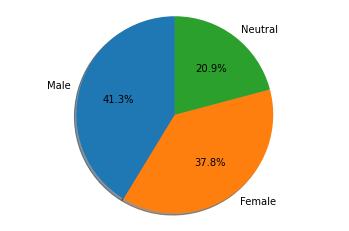

In [540]:
plot_gender([no_male,no_female,no_neutral])

## Tokenize

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

token_train = train.map(tokenize_function,batched=True)
token_valid = valid.map(tokenize_function,batched=True)
token_test = test.map(tokenize_function,batched=True)

token_train = token_train.remove_columns(['text'])
token_valid = token_valid.remove_columns(['text'])
token_test = token_test.remove_columns(['text'])

token_train.set_format("torch")
token_valid.set_format("torch")
token_test.set_format("torch")

In [542]:
train_dataloader = DataLoader(
    token_train, shuffle=True, batch_size=64, collate_fn=data_collator)

eval_dataloader = DataLoader(
    token_valid, batch_size=64, collate_fn=data_collator)

test_dataloader = DataLoader(
    token_test, batch_size=64, collate_fn=data_collator)

#### sanity check

In [543]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)
model.to(device);

In [ ]:
batch = next(iter(train_dataloader)).to(device)
labels = batch.pop('labels')
outputs = model(**batch)
logits = outputs.logits
weights = torch.tensor([0.6, 0.3, 0.1]).to(device)
loss_fct = torch.nn.CrossEntropyLoss(weight=weights)
loss_fct(logits,labels)

tensor(1.0974, device='cuda:0', grad_fn=<NllLossBackward>)

## Training

### weighted training

In [549]:
class_samples = [no_neutral,no_female,no_male]

#Inverse of Number of Samples
weights_ins = 1.0 / np.array(class_samples)
weights_ins = weights_ins / sum(weights_ins)

#Inverse of Square Root of Number of Samples
weights_isns = 1.0 / np.array(np.power(class_samples,0.5))
weights_isns = weights_isns / sum(weights_isns)

#Effective Number of Samples
beta = 0.999
weight_for_samples = (1.0 - beta) / (1.0 - np.power(beta,class_samples))
weights_ens = weight_for_samples / sum(weight_for_samples)

weights = torch.tensor([weights_ins,weights_isns,weights_ens]).float().to(device)

In [550]:
weights

tensor([[0.4862, 0.2681, 0.2457],
        [0.4076, 0.3027, 0.2897],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')

In [551]:
class WeightedTrainer(Trainer):
    def __init__(self,weights, *args, **kwargs):
        super(WeightedTrainer, self).__init__(*args, **kwargs)
        self.weights = torch.tensor(weights).to(device)
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop('labels')
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.weights)
        loss = loss_fct(logits,labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)
model.to(device);

training_args = TrainingArguments(
    output_dir='../',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=64, # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate  
    save_steps=5000,
    disable_tqdm = False,
    save_total_limit=2,
    weight_decay=0.01)               # strength of weight decay

trainer = WeightedTrainer(
    weights[1], #isns
    model,
    training_args,
    train_dataset=token_train,
    eval_dataset=token_valid,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [488]:
trainer.train()

***** Running training *****
  Num examples = 100000
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4689


Step,Training Loss
500,0.465200
1000,0.285800
1500,0.251100
2000,0.176900
2500,0.165500
3000,0.159100
3500,0.105800
4000,0.095000
4500,0.090100




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=4689, training_loss=0.19472527580236823, metrics={'train_runtime': 1130.4029, 'train_samples_per_second': 265.392, 'train_steps_per_second': 4.148, 'total_flos': 9796320991791936.0, 'train_loss': 0.19472527580236823, 'epoch': 3.0})

In [489]:
torch.save(model.state_dict(),'../isns_cs.pth')

In [554]:
model.load_state_dict(torch.load('../isns_cs.pth'))
model.eval();

# Eval on test data

F1 score: 0.9023802451034855
Accuracy score: 0.9177646524307133

Confusion matrix, without normalization


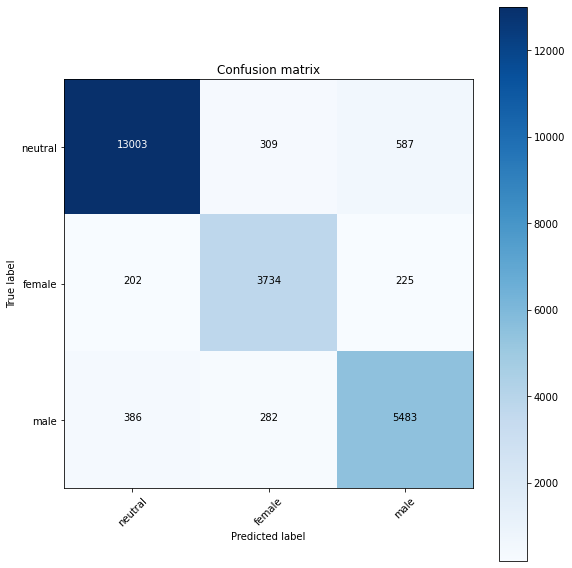

In [559]:
eval_test(test_dataloader,model,test['labels'])

# Eval on md_gender gold labeled dataset

In [ ]:
new_data = load_dataset('md_gender_bias','new_data')
new_data_filtered = new_data['train'].filter(lambda x: x['class_type'] == 0)

dictionary = {'text': new_data_filtered['text'], 'labels' : list(map(lambda x: x[0]+1,new_data_filtered['labels']))}
new_data_final = Dataset.from_dict(dictionary)
labels_new = new_data_final['labels']

with open(data_path + NEW_VALID,'r') as val_file:
    new_valid_texts = val_file.read().splitlines()
    
dictionary = {'text': new_valid_texts, 'labels' : labels_new}
new_data_cs = Dataset.from_dict(dictionary)

In [ ]:
tokenized_final = new_data_cs.map(tokenize_function,batched=True)

tokenized_final = tokenized_final.remove_columns(['text'])
tokenized_final.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

new_data_test = DataLoader(
    tokenized_final, batch_size=tokenized_final.num_rows, collate_fn=data_collator)

F1 score: 0.8011315656139166
Accuracy score: 0.8012738853503185

Confusion matrix, without normalization


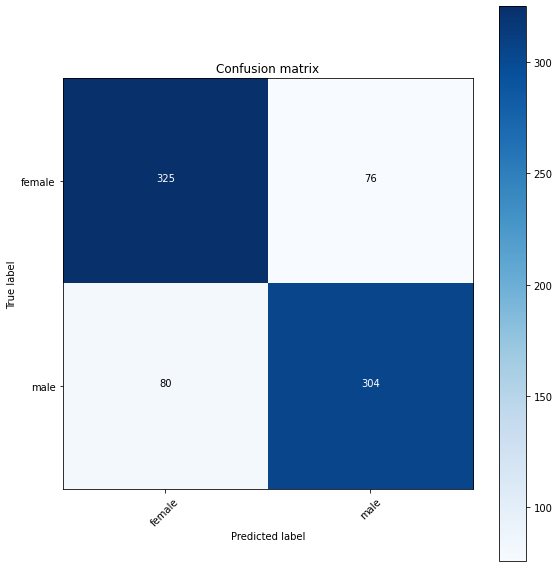

In [562]:
metric1 = load_metric("f1")
metric2 = load_metric("accuracy")
indices = torch.tensor([1,2]).to(device)
preds = torch.Tensor([]).to(device)


model.eval()
for batch in new_data_test:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    
    logits = outputs.logits
    #throw away neutral class column
    logits = torch.index_select(logits, 1, indices)
    
    preds = torch.cat((preds,logits),0)
    predictions = torch.argmax(logits, dim=-1) + 1
    metric1.add_batch(predictions=predictions, references=batch["labels"])
    metric2.add_batch(predictions=predictions, references=batch["labels"])
    
score = metric1.compute(average="macro")
score2 = metric2.compute()
print("F1 score: " + str(score['f1']))
print("Accuracy score: " + str(score2['accuracy']) + "\n")

labels = torch.tensor(labels_new)
preds = F.softmax(preds,dim=1).argmax(dim=1) + 1

cm = confusion_matrix(labels,preds.cpu())
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,['female','male'])

### Some experiments with czech data

In [563]:
def classify(idx):
    return ['Neutral','Female','Male'][idx]
def classify_sentence(sentence:str):
    sentence = tokenizer(sentence,truncation=True,return_tensors="pt")
    model.eval()
    with torch.no_grad():
        sentence.to(device)
        output = model(**sentence)
    
        classification = F.softmax(output.logits,dim=1).argmax(dim=1)
        return ['Neutral','Female','Male'][classification.item()]

In [576]:
text = ('O letošním držiteli ceny rozhodli předsedové parlamentních politických skupin, Navalného přitom nominovali zástupci Evropské lidové strany'
        '(EPP) a frakce Obnova Evropy (Renew Europe). „Pane Putine, propusťte Alexeje Navalného,“ uvedla EPP na svém oficiálním twitterovém účtu.' 
        '„Evropa volá po svobodě jeho i všech dalších politických vězňů,“ pokračuje prohlášení. Mezi dalšími nominovanými byla rovněž vězněná '
        'exprezidentka Bolívie Jeanine Áňezová a skupina afghánských aktivistek. Afghánské ženy se EP rozhodl ocenit tím, že věnuje celý týden' 
        'aktivitám, jejichž cílem bude povzbudit zájem veřejnosti o jejich situaci, oznámila Hautalová.')

In [580]:
small_article = text.split('.')

In [581]:
result = list(map(classify_sentence,small_article))

In [582]:
result

['Male', 'Male', 'Male', 'Female', 'Female', 'Neutral']